# The preceeding ipynb is semi more general in selecting it's blurring region.
# It is capable of selecting cuboid, i.e. unequal sides
# This ipynb restricts to only cubes, i.e. equal sides, as an attempt to be more computationally efficient
# The reason for this restriction relies on the assumption that the blurring region are spheres

## Importing Libraries

In [93]:
%matplotlib inline
import matplotlib.pyplot as plt
import logging
import numpy as np
import py21cmfast as p21c

## Cosmological Parameters (Default is used when no input is specified)

In [94]:
cosmo_params = p21c.CosmoParams()

## User Parameters, like box length, number of voxels (i.e. resolution) etc.

In [95]:
BOX_LEN = 301

user_params = p21c.UserParams(
    BOX_LEN=BOX_LEN,  # Box length
    DIM=2*BOX_LEN,      # Number of Voxels for hight resolution 
    HII_DIM=BOX_LEN  # Number of Voxels for low resolution 
)

## Creating initial conditions box

In [96]:
init_cond = p21c.initial_conditions(
    cosmo_params=cosmo_params,
    user_params=user_params
)

## Gaussian function

In [97]:
def Gaussian(x, sigma=1, mu=0):
    return (1/sigma/np.sqrt(2*np.pi))*(np.exp(-0.5*(((x-mu)/sigma)**2)))

## Measure the distance of each voxel to the center

In [98]:
def distance_from_coordinate(box_length):
    
    index = np.arange(-0.5*(box_length-1), 0.5*(box_length+1))

    x_mesh, y_mesh, z_mesh = np.meshgrid(index, index, index, indexing='ij')
    
    distance = np.sqrt((x_mesh)**2 + (y_mesh)**2 + (z_mesh)**2)
    
    return distance

## Random Coordinate

In [99]:
def random_voxel(box_length):
    
    np.random.seed()  # set seed to a randome number
#     np.random.seed(4) ; np.random.rand(10)

    coordinate = np.random.randint(0, box_length, size=3)

    return coordinate

## Select a Smaller Cube with Sides 2R+1 Voxels, Centered about the Random Coordinate

In [100]:
def cube_centered_about_coordinate(coordinate_array, radius, box):
    x_ind1 = coordinate_array[0]-radius  # x-domian
    x_ind2 = coordinate_array[0]+radius+1  # ending index is not inclusive
    y_ind1 = coordinate_array[1]-radius  # y-domain
    y_ind2 = coordinate_array[1]+radius+1
    z_ind1 = coordinate_array[2]-radius  # z-domain
    z_ind2 = coordinate_array[2]+radius+1

    if x_ind1 < 0:  # periodic boundary conditions
        x_inds = np.r_[(x_ind1+box.shape[0]):box.shape[0], 0:x_ind2]
    elif x_ind2 > box.shape[0]:
        x_inds = np.r_[x_ind1:box.shape[0], 0:(x_ind2-box.shape[0])]
    else:
        x_inds = np.r_[x_ind1:x_ind2]

    if y_ind1 < 0:
        y_inds = np.r_[(y_ind1+box.shape[1]):box.shape[1], 0:y_ind2]
    elif y_ind2 > box.shape[1]:
        y_inds = np.r_[y_ind1:box.shape[1], 0:(y_ind2-box.shape[1])]
    else:
        y_inds = np.r_[y_ind1:y_ind2]

    if z_ind1 < 0:
        z_inds = np.r_[(z_ind1+box.shape[2]):box.shape[2], 0:z_ind2]
    elif z_ind2 > box.shape[2]:
        z_inds = np.r_[z_ind1:box.shape[2], 0:(z_ind2-box.shape[2])]
    else:
        z_inds = np.r_[z_ind1:z_ind2]

    indices = np.ix_(x_inds, y_inds, z_inds)
    
    output_box = box[indices]
    
    return output_box

## Gausssian Averaging

In [101]:
def gaussian_sphere_average_value(distance_box, radius, input_box, shell_num, sigma_factor):
    
    mean = []

    shell_radius_edges = np.linspace(0,1,shell_num+1)
    shell_center = 0.5*(shell_radius_edges[1:] + shell_radius_edges[:-1])
    weight = Gaussian(x=shell_center*sigma_factor)

    for ii in range(shell_num):
        condition = np.logical_and(distance_box <= shell_radius_edges[ii+1]*radius, distance_box > shell_radius_edges[ii]*radius)
        inside_shell_mean = np.mean(input_box[condition])
        mean = np.append(mean, inside_shell_mean)
        
    Gaussian_mean = np.average(mean, weights=weight)
    
    return Gaussian_mean

## Sphere Blurring Function

In [102]:
def Average_Neutral_Fraction_Distribution(box, radius, iteration, shell_num=1, sigma_factor=4):
    
    box = box.copy()  # make copy of input box to have a separate box
    
    dist_frm_coord_box = distance_from_coordinate(radius*2+1)

    inside_sphere_mean_data = []  # empty list for data collection
    
    for i in range(iteration):
        
        rand_coord = random_voxel(len(noise_box))
                
        cube_region_box = cube_centered_about_coordinate(rand_coord, radius, box)
        
        inside_sphere_mean = gaussian_sphere_average_value(dist_frm_coord_box, radius, cube_region_box, shell_num, sigma_factor)
        
        inside_sphere_mean_data = np.append(inside_sphere_mean_data, inside_sphere_mean)
        
    return np.array(inside_sphere_mean_data)

## Histogram Function

In [132]:
def histogram(fs, x_start=0, x_stop=1, bin_num=100, color='white', title=None, figure_size=(18,7), font_size=15):  # a: x start, b: x stop
    bin_edges = np.linspace(x_start, x_stop, bin_num) # 100 bins from 0-1
    bin_centers = 0.5 * (bin_edges[1:] + bin_edges[:-1])
    fig, axes = plt.subplots(1, len(fs), figsize=figure_size, sharex=True, sharey=True, gridspec_kw={"hspace":0.05, 'wspace': 0.05})
    for i, f in enumerate(fs):
        axes[i].plot(bin_centers, np.histogram(f, bins=bin_edges)[0])
#         axes[i].set_aspect('equal', 'box')
        axes[i].set_title(title[i], color=color, fontsize=font_size)
        axes[i].tick_params(color=color, labelcolor=color, labelsize=font_size)  # figure color
        for spine in axes[i].spines.values():
            spine.set_edgecolor(color)

## Creating Ionize box

In [104]:
z = 6.5
ionized = p21c.ionize_box(redshift=z, init_boxes=init_cond).xH_box

## Creating Noise Box

In [105]:
np.random.seed()
# np.random.seed(5) ; np.random.rand(10)
noise_box = np.random.rand(301, 301, 301)

## Blurring the box

In [205]:
Sphere12 = Average_Neutral_Fraction_Distribution(box=noise_box, radius=7, iteration=10**5, shell_num=1, sigma_factor=1)

In [117]:
Sphere3 = Average_Neutral_Fraction_Distribution(box=noise_box, radius=3, iteration=10**5, shell_num=1, sigma_factor=1)

In [118]:
Gaussian1 = Average_Neutral_Fraction_Distribution(box=noise_box, radius=10, iteration=10**5, shell_num=6, sigma_factor=1.4370396997748922)

In [119]:
Gaussian2 = Average_Neutral_Fraction_Distribution(box=noise_box, radius=10, iteration=10**5, shell_num=6, sigma_factor=4)

In [120]:
Gaussian3 = Average_Neutral_Fraction_Distribution(box=noise_box, radius=13, iteration=10**5, shell_num=6, sigma_factor=3*1.4370396997748922)

In [227]:
Gaussian4 = Average_Neutral_Fraction_Distribution(box=noise_box, radius=14, iteration=10**5, shell_num=6, sigma_factor=3*1.4370396997748922)

## Creating Histogram

# Distribution of average values of a noise box

In [228]:
var_diff = ['{:.3e}'.format(np.abs(np.var(Sphere12) - np.var(Gaussian1))), '{:.3e}'.format(np.abs(np.var(Sphere12) - np.var(Gaussian2))), '{:.3e}'.format(np.abs(np.var(Sphere) - np.var(Gaussian3))), '{:.3e}'.format(np.abs(np.var(Sphere) - np.var(Gaussian4)))]

In [229]:
print(var_diff)

['2.090e-04', '1.170e-03', '1.010e-04', '2.279e-04']


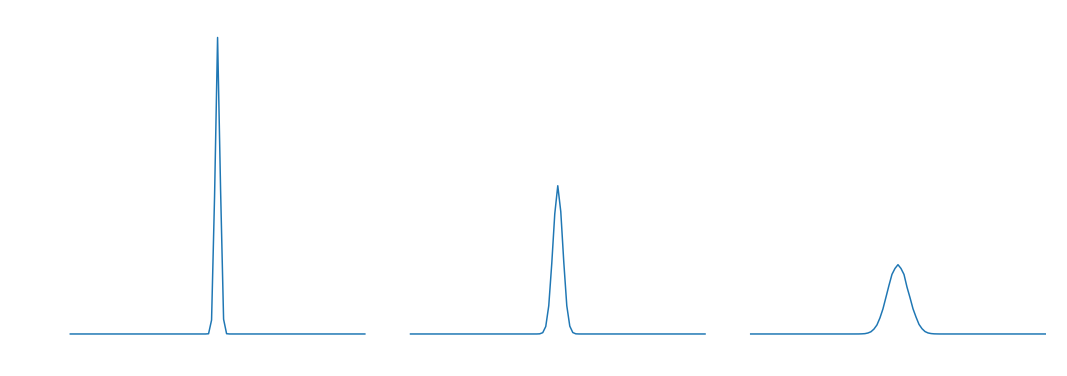

In [223]:
histogram([Sphere12, Gaussian1, Gaussian2], title=['Sphere 1 & 2', f'Gaussian, Option 1, var_diff={var_diff[0]}', f'Gaussian, Option 2, var_diff={var_diff[1]}'], figure_size=(18,6), font_size=13)

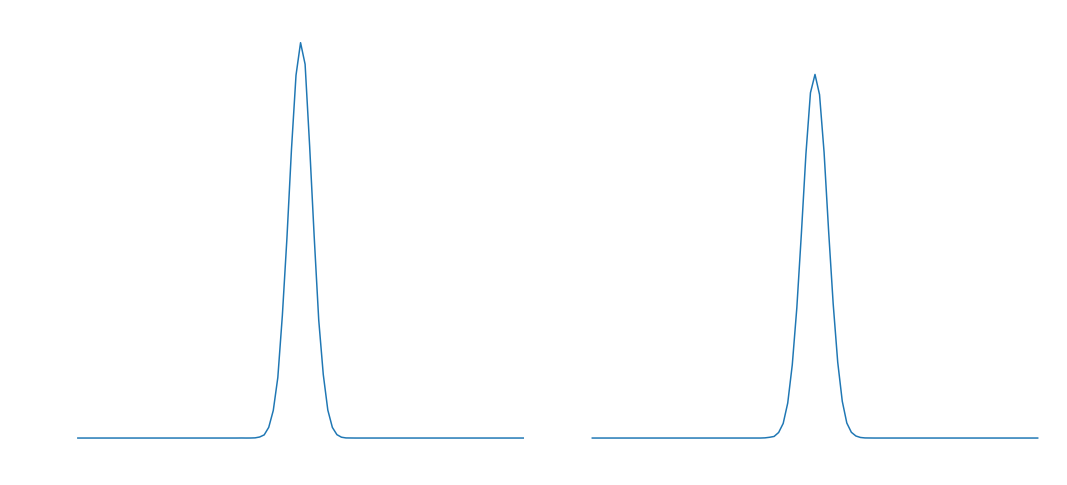

In [217]:
histogram([Sphere, Gaussian3], title=['Sphere 3', f'Gaussian, Option 3, var_diff={var_diff[2]}'], figure_size=(18,8), font_size=13)

In [ ]:
histogram([Sphere, Gaussian4], title=['Sphere 3', f'Gaussian, Option 4, var_diff={var_diff[3]}'], figure_size=(18,8), font_size=13)

In [ ]:
a = np.arange(1,101)
b = 1.4370396997748922*a
print(a, b)

In [204]:
10.0592779/(1.4370396997748922)

7.000000001096528

In [195]:
aa = [np.var(Sphere) - np.var(Gaussian1), np.var(Sphere) - np.var(Gaussian2), np.var(Sphere) - np.var(Gaussian3)]

In [196]:
print(aa)

[0.0004122366140345594, -0.0005487027566763897, -0.00010102685654476658]


In [198]:
np.min(np.abs(aa))

0.00010102685654476658

In [155]:
'{:.6}'.format(np.var(Sphere) - np.var(Gaussian1))

'0.000412237'

In [157]:
'{:.4e}'.format(np.var(Sphere) - np.var(Gaussian1))

'4.1224e-04'